# Align Polar 5G Rate-Matching + Decoding

This notebook compares the results with Fig. 13a from
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8962344

Please note that not all rates are possible (as no code segmentation is supported yet)

In [1]:
num_GPU = 1

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.8.0
Number of GPUs available : 2
Only GPU number 1 used


## Import required packages

In [2]:
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
    
# Load Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.polar.encoding import Polar5GEncoder
from sionna.fec.polar.decoding import Polar5GDecoder
from sionna.utils import BinarySource, ebnodb2no
from sionna.utils.metrics import count_block_errors
from sionna.channel import AWGN

In [9]:
# reproducing the results from 
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8962344

class Polar_BLER(tf.keras.Model):
    def __init__(self,
                 k,
                 n):
        super().__init__()
        
        self.n = n
        self.k = k

        # decoder parameters ()
        decoder_type = "SCL" 
        list_size = 8 

        self.enc = Polar5GEncoder(self.k, self.n)
        self.dec = Polar5GDecoder(self.enc, 
                                dec_type=decoder_type,
                                list_size=list_size)

        # init system components
        self.source = BinarySource() # generates random info bits
        self.constellation = Constellation("qam", # QPSK
                                num_bits_per_symbol=2)
        self.mapper = Mapper(constellation=self.constellation)
        self.channel = AWGN()
        self.demapper = Demapper("app", constellation=self.constellation) # APP demapper

    @tf.function()
    def run_dec(self, llr_ch):
        u_hat = self.dec(llr_ch) # run Polar decoder
        return u_hat

    def run_ber(self, batch_size, esno_db):
        
        # esno_db; no rate adjustement
        no = ebnodb2no(esno_db, num_bits_per_symbol=1, coderate=1)
        u = self.source([batch_size, self.k]) # generate random bit sequence
        c = self.enc(u) # Polar encode 
        x = self.mapper(c) # map to symbol (QPSK)
        y = self.channel([x, no]) # transmit over AWGN channel   
        llr_ch = self.demapper([y, no]) # demapp

        # call decoder as tf.function
        u_hat = self.run_dec(llr_ch)

        # coun and return errors
        num_wer = count_block_errors(u, u_hat)
        return num_wer
    
    def find_threshold(self):
        """Bisection search to find required SNR to reach target SNR."""
        batch_size = 1000
        max_batch_iter = 10 # simulate cws up to batch_size * max_batch_iter
        max_wer = 100  # number of errors before stop
        target_wer = 1e-3 # target error rate to simulate (given by ref. paper)

        # bisection parameters
        esno_db_min = -25
        esno_db_max = 15
        esno_interval = (esno_db_max-esno_db_min)/4
        esno_db = 2*esno_interval + esno_db_min
        max_iters = 12 # iters for bisection search

        # run bisection
        for i in range(max_iters):
            num_wer = 0
            num_cws = 0
            for j in range(max_batch_iter):
                num_wer += self.run_ber(batch_size, esno_db)
                num_cws += batch_size
                if num_wer>max_wer:
                    break
            wer = num_wer/num_cws
            if wer>target_wer:
                esno_db += esno_interval        
            else:
                esno_db -= esno_interval 
            esno_interval = esno_interval/2
        return esno_db

In [10]:
# run simulations for multiple code parameters
ks = np.array([12, 16, 32, 64, 128, 140, 210, 220, 256, 300, 400, 450, 460, 512, 800, 880, 940])
ns = np.array([160, 240, 480, 960])

esno = np.zeros([len(ns), len(ks)])

for j,n in enumerate(ns):  
    for i,k in enumerate(ks):        
        if k<n: 
            print(k)
            print("Finding threshold of k = {}, n = {}".format(k, n))
            model = Polar_BLER(int(k), int(n))
            esno[j, i] = model.find_threshold()
            print("Found threshold at: ", esno[j, i])
print(esno)

12
Finding threshold of k = 12, n = 160
Found threshold at:  -4.4580078125
16
Finding threshold of k = 16, n = 160
Found threshold at:  -3.4130859375
32
Finding threshold of k = 32, n = 160
Found threshold at:  -0.5908203125
64
Finding threshold of k = 64, n = 160
Found threshold at:  2.5048828125
128
Finding threshold of k = 128, n = 160
Found threshold at:  6.8408203125
140
Finding threshold of k = 140, n = 160
Found threshold at:  8.1982421875
12
Finding threshold of k = 12, n = 240
Found threshold at:  -6.2060546875
16
Finding threshold of k = 16, n = 240
Found threshold at:  -5.3173828125
32
Finding threshold of k = 32, n = 240
Found threshold at:  -2.5341796875
64
Finding threshold of k = 64, n = 240
Found threshold at:  0.0048828125
128
Finding threshold of k = 128, n = 240
Found threshold at:  3.2763671875
140
Finding threshold of k = 140, n = 240
Found threshold at:  3.9111328125
210
Finding threshold of k = 210, n = 240
Found threshold at:  7.7392578125
220
Finding threshold 

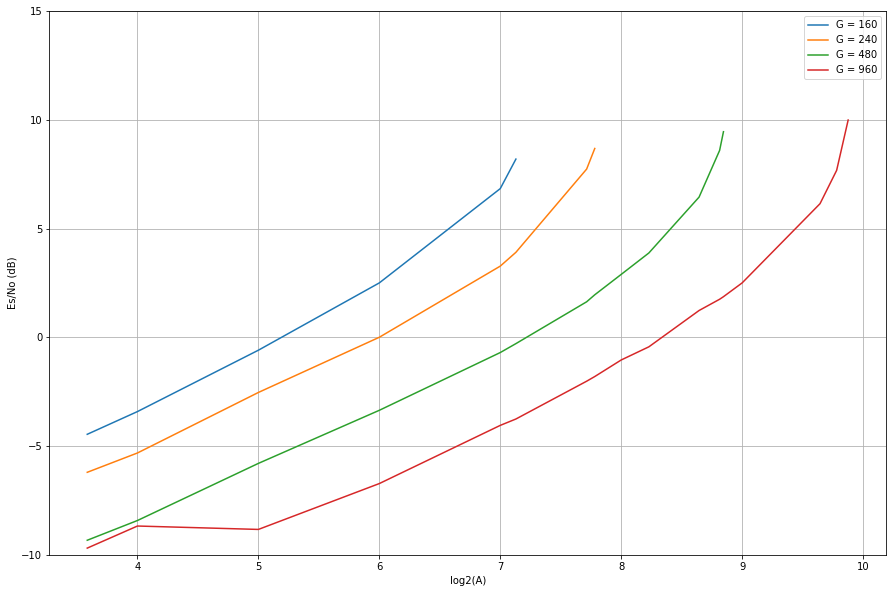

In [13]:
# and plot the results
leg_str = []
for j,n in enumerate(ns): 
    plt.plot(np.log2(ks[ks<n]), esno[j, ks<n])
    leg_str.append("G = {}".format(n))

plt.grid("both")
#plt.xlim([30, 1024])
plt.ylim([-10, 15])
plt.xlabel("log2(A)")
plt.ylabel("Es/No (dB)")
plt.legend(leg_str);
x = plt.gcf()
x.set_size_inches(15,10)

See reference in Fig. 13a from
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8962344

Remark: baseline uses SCL-8 (solid curves): the dashed curves show the Polyanskyi-Poor-Verdu meta converse

Remark2: Please note that the slight degradation for k<20 stems from the missing 3 additional PC bits.

Remark3: Please note that the G=960 performance for k=16 is degraded (probably due to the missing PC bits and the extrem low rate)